In [2]:
%matplotlib inline
from astropy.cosmology import LambdaCDM
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
import astropy.units as u
from scipy.integrate import quad
import ezgal # BC03 model maker
import os

# Setup Cosmology

In [3]:
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7, Tcmb0=2.725)

# Create Stellar Population

In [4]:
# check to make sure we have defined the bpz filter path
if not os.getenv('EZGAL_FILTERS'):
    os.environ['EZGAL_FILTERS'] = (f'{os.environ["HOME"]}/Projects/planckClusters/MOSAICpipe/bpz-1.99.3/FILTER/')

model = ezgal.model('bc03_ssp_z_0.02_salp.model')
model = model.make_exponential(1)
model.set_cosmology(Om=cosmo.Om0, Ol=cosmo.Ode0, h=cosmo.h, w=cosmo.w(0))
                                   
model.add_filter('g_MOSAICII.res', name='g')
model.add_filter('r_MOSAICII.res', name='r')
model.add_filter('i_MOSAICII.res', name='i')
model.add_filter('z_MOSAICII.res', name='z')
model.add_filter('K_KittPeak.res', name='K')

# Blanton 2003 Normalization
Mr_star = -20.44 + 5 * np.log10(cosmo.h) # abs mag.
# set the normalization
model.set_normalization('sloan_r', 0.1, Mr_star, vega=False)                                   

/home/boada/.local/lib/python3.6/site-packages/ezgal/data/models/bc03_ssp_z_0.02_salp.model


/home/boada/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:358: RuntimeWarning: divide by zero encountered in true_divide
  h0divh1 = h0 / h1
/home/boada/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:360: RuntimeWarning: divide by zero encountered in true_divide
  y[slice1]*hsum*hsum/hprod +
/home/boada/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:361: RuntimeWarning: invalid value encountered in add
  y[slice2]*(2-h0divh1))


# Calculate a few things to get going.

In [5]:
# desired formation redshift
zf = 6.0
# fetch an array of redshifts out to given formation redshift
zs = model.get_zs(zf)

# Calculate some cosmological stuff
DM = cosmo.distmod(zs)
dlum = cosmo.luminosity_distance(zs)

# Define the functions that we'll need

Need to compute the cluster volume...

$M_{vir} = 4/3 \pi r^3_{vir} \rho_c(r<r_{vir}) = 4/3 \pi r^3_{vir} \Delta_c \rho_c$

if we let $\Delta_c = 200$ then 

$M_{200} = 4/3 \pi r^3_{200} 200 \rho_c$ with $\rho_c = \frac{3H(z)^2}{8\pi G}$

or just $M_{200} = V_{200}200\rho_c$. So we'll make a function to calculate $\rho_c$. And we'll make use of the astropy units package to do all the unit analysis for us.

Don't forget that $H(z) = H_0E(z)$ 

## We also need to integrate the Schechter luminosity functions..

The Schechter Function:

For Luminosity:

$\Phi(L) = \phi^\star \frac{L}{L_\star}^\alpha e^{-\frac{L}{L_\star}}$

For Magnitudes:

$\Phi(M) = \phi^\star\frac{2}{5}log(10) (10^{\frac{2}{5}(M_\star - M)})^{\alpha+1} e^{-10^{\frac{2}{5}(M_\star - M)}}$




In [6]:
def rho_crit(z, cosmo):
    # convert G into better units:
    G = const.G.to(u.km**2 * u.Mpc/(u.M_sun * u.s**2))
    return 3 / (8 * np.pi * G) * cosmo.H0**2 * cosmo.efunc(z)**2 # Mpc^3

def schechterL(luminosity, phiStar, alpha, LStar): 
    """Schechter luminosity function.""" 
    LOverLStar = (luminosity/LStar) 
    return (phiStar/LStar) * LOverLStar**alpha * np.exp(- LOverLStar) 

def schechterM(magnitude, phiStar, alpha, MStar): 
    """Schechter luminosity function by magnitudes.""" 
    MStarMinM = 0.4 * (MStar - magnitude) 
    return (0.4 * np.log(10) * phiStar * 10.0**(MStarMinM * (alpha + 1.)) * np.exp(-10.**MStarMinM))

# Start Calculating things

In [20]:
# So now we are going to calculate the volumes as a function of z
M200 = 1e15 * u.solMass
V200 = M200/ (200 * rho_crit(zs, cosmo))

# calculate the abs mag of our limiting magnitude as a function of z
mlim = 20
Mlim = mlim - cosmo.distmod(zs).value - model.get_kcorrects(zf, filters='r', zs=zs)

# Calculate the M_star values
Mstar = model.get_absolute_mags(zf, filters='r', zs=zs)

# Here are the Schechter function stuff from Liu et al.
phi_star = 3.6 * cosmo.efunc(zs)**2
alpha = -1.05 * (1 + zs)**(-2/3)
fr = 0.8*(1 + zs)**(-1/2)

# Integrate

In [21]:
LF = []
for phi, a, M_star, M_lim in zip(phi_star, alpha, Mstar, Mlim):
    y, err = quad(schechterM, -np.inf, M_lim, args=(phi, a, M_star))
    LF.append(y)

/home/boada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  


# Plot

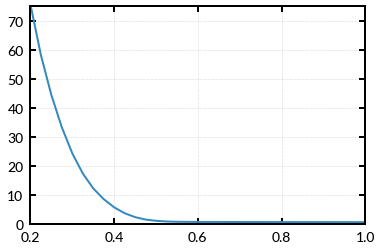

In [22]:
plt.plot(zs, (LF * V200.value + 1) * fr)
ax = plt.gca()
ax.set_yticks(np.arange(0, 75, 10))
plt.xlim(0.2, 1)
plt.ylim(0, 75)
plt.grid()

AttributeError: 'AxesSubplot' object has no attribute 'set_y'